# Exploring Ice sheet Gravimetric Mass Balance data, available through the C3S Climate Data Store
 
By Sebastian B. Simonsen and Natalia Havelund, DTU Space, 
Comments can be posted to S. Simonsen at ssim@dtu.dk 

## About

This tutorial will demonstrate how to plot the Gravimetric Mass Balance (GMB) data for selected regions across the Greenland or Antarctic ice sheets, using data from the Copernicus Climate Change Service (C3S). Gravimetric Mass Balance refers to the changes in the mass of ice sheets determined from satellite gravimetry, which measures variations in the Earth's gravity field due to ice mass changes. These data are crucial for understanding how ice sheets contribute to sea level rise.

The GMB data provides estimates of ice mass loss or gain over time, derived from satellite-based gravimetric measurements from the GRACE and GRACE-FO satellites. These measurements track changes in the gravitational field caused by shifts in mass, such as the movement or melting of ice. The GMB data allows researchers to monitor long-term trends in ice sheet dynamics and their contribution to global sea level changes.

It will show you how to download data from the C3S Climate Data Store (CDS), calculate average change rates over a selectable period, and display the results.

## Data Description:

Source   :    Copernicus Climate Change Service (C3S) Climate Data Store (CDS) 

Data Type:    Satellite-based gravimetric measurements

Coverage :    Greenland and Antarctic ice sheets

Variables:    Time series of mass balance changes over specific regions with basin numbers

Format   :    NetCDF4 files


## Prepare your environment

To download data from the CDS, you must complete three steps;
1. Register for free with the CDS at https://cds.climate.copernicus.eu/#!/home
2. Set up the CDS Application Program Interface (API), as described at https://cds.climate.copernicus.eu/how-to-api
3. Agree to the dataset terms of use - if you have not already done so you will be directed to the correct webpage the first time you try to download data. Accept the terms and conditions, and re-run the downloading code.

## Import libraries

The data is stored in netCDF4 files. To work with them, several libraries are needed. These are used to retrieve the data, unpack it, run calculations and plot the results.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# CDS API
import cdsapi

# File handling
import shutil
import glob
import os

# Calculations
import numpy as np
import xarray as xr

# Mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm


## Download data

Select the ice sheet of interest and retrieve the dataset. An example of how to retrieve the data is given on the CDS, under 'Show API request' on the dataset's webpage at https://cds.climate.copernicus.eu/datasets/satellite-ice-sheet-mass-balance?tab=download

The dataset comes in a zip file, and may include several files. Only the most recent is necessary - this contains all of the data in previous files, plus the latest update. 

## The user first chooses which ice sheet they want to plot: 

In [3]:
# Set ice_sheet to the desired ice sheet, either 'AntIS' or 'GrIS'
# This will be used to select data, and later to set up plot defaults

#ice_sheet = 'AntIS' # 

ice_sheet = 'GrIS' # 


try:
    
    # Download data from the CDS

    import cdsapi

    c = cdsapi.Client()

    c.retrieve(
        'satellite-ice-sheet-mass-balance',
        {
            'variable': 'all',
            'format': 'zip',
        },
        'download.zip')

    # Unpack the zip file and remove the zipped data

    shutil.unpack_archive('download.zip', '.')
    os.remove('download.zip')
except:
     pass

# # List the files contained and select the latest netCDF (.nc) file. Print its filename

list_of_files = glob.glob('*.nc') # * means all if need specific format then *.nc
latest_file = max(list_of_files, key=os.path.getctime)
print('In the following you are seeing the data from: \n'+latest_file)


2024-10-11 12:34:14,764 WARNING [2024-10-11T10:34:14.730486] You are using a deprecated API endpoint. If you are using cdsapi, please upgrade to the latest version.
2024-10-11 12:34:14,928 INFO status has been updated to accepted
2024-10-11 12:34:16,525 INFO status has been updated to running
2024-10-11 12:34:18,894 INFO status has been updated to successful


a5dd2a38588689942e6fcf2c75027744.zip:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

In the following you are seeing the data from: 
C3S_GMB_GRACE_vers4.nc


## Examine the data

Open the data file and list its contents. These include descriptive comments.

In [4]:
# Open the NetCDF file

ds = xr.open_dataset(latest_file)

# Print contents list
print('The data file contains the following:')
print(ds)


The data file contains the following:
<xarray.Dataset> Size: 14MB
Dimensions:                (t: 216, AntB: 901322, N: 3, GrisB: 272965)
Dimensions without coordinates: t, AntB, N, GrisB
Data variables: (12/81)
    time                   (t) datetime64[ns] 2kB ...
    AntBasin               (AntB, N) float32 11MB ...
    GrISBasin              (GrisB, N) float32 3MB ...
    GrIS_total             (t) float32 864B ...
    GrIS_total_er          (t) float32 864B ...
    GrIS_1                 (t) float32 864B ...
    ...                     ...
    East_AntIS_total       (t) float32 864B ...
    East_AntIS_total_er    (t) float32 864B ...
    West_AntIS_total       (t) float32 864B ...
    West_AntIS_total_er    (t) float32 864B ...
    AntIS_total            (t) float32 864B ...
    AntIS_total_er         (t) float32 864B ...
Attributes:
    Title:                GMB for Greenland and Antarctica ice sheets from th...
    institution:          DTU Space - Geodesy and Earth Observations
 

# Choosing the drainage basin to plot

Here the user can get an overview of the drainage basins available for the chosen Ice Sheet 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


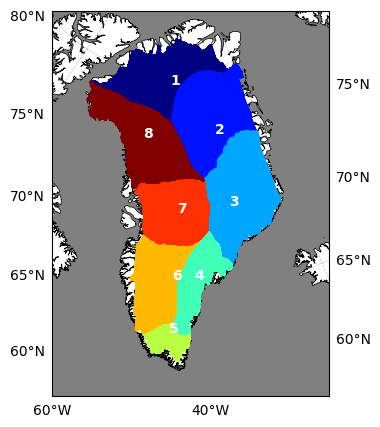

In [5]:

# Load data
time_in_hours = ds['time']
time_in_hours_array = time_in_hours.values

if 'GrIS' in ice_sheet:
    drainage_basin = ds['GrISBasin']
    basin_range = range(1, 9)  # For GrIS: 1 to 8
    cmap = plt.colormaps['jet']
elif 'AntIS' in ice_sheet:
    drainage_basin = ds['AntBasin']
    basin_range = range(1, 28)  # For AntIS: 1 to 27
    cmap = plt.colormaps['jet']


# Create a figure and axis with a specific projection
fig = plt.figure(figsize=(12, 5))

if 'GrIS' in ice_sheet:
    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.Orthographic(-45, 71))
    ext = [-60, -25, 57, 84]
elif 'AntIS' in ice_sheet:
    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.Orthographic(0, -90))
    ext = [-180, 180, -90, -60]

ax1.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
ax1.set_extent(ext, crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, facecolor='white')
ax1.add_feature(cfeature.OCEAN, facecolor='gray')

# Add latitude and longitude gridlines
gl = ax1.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Generate colors from colormap
colors = cmap(np.linspace(0, 1, len(basin_range)))  # Get N distinct colors for the number of basins

for i, basin_num in enumerate(basin_range):
    # Filter data for the specific basin
    filtered_basins = drainage_basin.where((drainage_basin[:, 2] - basin_num).astype(int) == 0, drop=True)
    basin_numbers_str = filtered_basins[:, 2].astype(str)
    filtered_basins_2x = filtered_basins.where(basin_numbers_str.str.startswith(str(basin_num)+'.'), drop=True)
    
    # Extract latitude, longitude, and basin number
    lat, lon, basin_number = filtered_basins_2x[:,0].values, filtered_basins_2x[:,1].values, filtered_basins_2x[:,2].values
    
    # Sort coordinates by longitude
    sorted_indices = np.argsort(lon)
    lon_sorted = lon[sorted_indices]
    lat_sorted = lat[sorted_indices]
    
    # Plot the sorted coordinates
    ax1.plot(lon_sorted, lat_sorted, color=colors[i], linestyle='dashed', transform=ccrs.PlateCarree())
    
    # Calculate the midpoint
    midpoint_lat = np.mean(lat)
    midpoint_lon = np.mean(lon)
    
    # Add text to the middle of the lat-lon set
    ax1.text(midpoint_lon, midpoint_lat, str(basin_num), color='white', transform=ccrs.PlateCarree(), fontsize=10, fontweight='bold')

plt.show()


## Pick a drainage basin to view timeseries for: 

In [6]:

basin_num = 7 # if set 0, then mass loss for all is shown. For GrIS 0-8, for AntIS 0-27 basins


# Plotting the timeseries

## Loading the data

Here the data from the selected ice sheet is loaded based on the choosen basin number from above. 
The variables needed for the plotting below are also extracted here .

In [7]:
# Load data

time_in_hours = ds['time']

# Convert xarray DataArray to NumPy array
time_in_hours_array = time_in_hours.values

if 'GrIS' in ice_sheet:
    drainage_basin = ds['GrISBasin']


if 'AntIS' in ice_sheet:
    drainage_basin = ds['AntBasin']    

if basin_num != 0:        
    filtered_basins = drainage_basin.where((drainage_basin[:, 2] - basin_num).astype(int) == 0, drop=True)
    basin_numbers_str = filtered_basins[:, 2].astype(str)
    filtered_basins_2x = filtered_basins.where(basin_numbers_str.str.startswith(str(basin_num)+'.'), drop=True)
    
    # Extracting latitude, longitude, and basin number
    
    lat, lon, basin_number = filtered_basins_2x[:,0].values,filtered_basins_2x[:,1].values,filtered_basins_2x[:,2].values
 
    gmb = ds[str(ice_sheet)+'_'+str(round(basin_num))]
    gmb_er = ds[str(ice_sheet)+'_'+str(round(basin_num))+'_er']


else:
    
    lat, lon = drainage_basin[:,0].values,drainage_basin[:,1].values
    gmb = ds[str(ice_sheet)+'_total']
    gmb_er = ds[str(ice_sheet)+'_total_er']


# Setting up the plot

In this plot, we focus on displaying the specific basin area within the selected ice sheet. Each basin represents a predefined region, and its boundary is essential for understanding localized processes such as ice mass changes or environmental conditions. The boundary of the basin is highlighted on the geographical map. This serves as a spatial reference for understanding which part of the ice sheet is being analyzed in the accompanying time series graph.

## Key Components:

Basin Area Map: The geographical map shows the specific basin number selected for analysis. It helps orient the user by providing a visual representation of the area under consideration within the larger ice sheet. This is useful for understanding the spatial context of the following analysis.

Time Series Graph: 
Next to the basin map, a graph is displayed that tracks the mass change over time within the selected basin. This graph is where the data is visualized, providing insights into whether the basin has been gaining or losing ice mass over time. The combination of the basin map and time series graph allows us to interpret the temporal changes in mass for a specific region of the ice sheet.

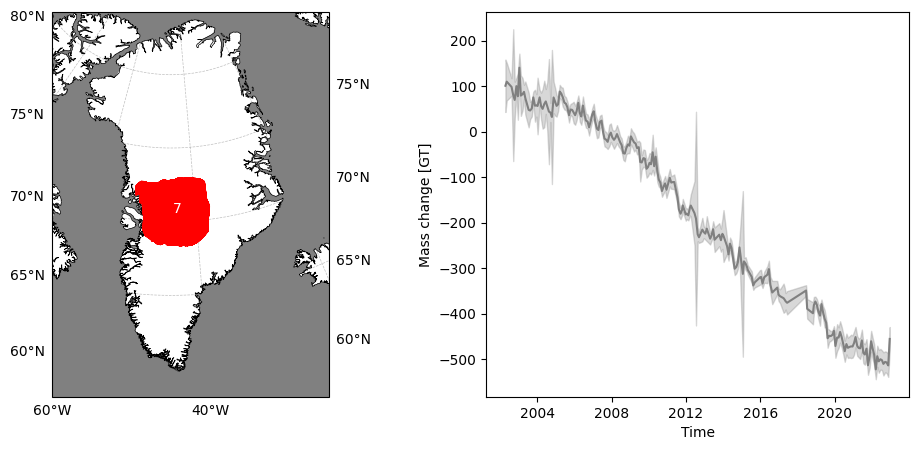

In [8]:

# Create a figure and axis with a specific projection
fig = plt.figure(figsize=(12, 5))

# Create the first subplot with a projection
if 'GrIS' in ice_sheet:
    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.Orthographic(-45, 71))
    ext = [-60, -25, 57, 84]
elif 'AntIS' in ice_sheet:
    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.Orthographic(0, -90))
    ext = [-180, 180, -90, -60]

ax1.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
ax1.set_extent(ext, crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, facecolor='white')
ax1.add_feature(cfeature.OCEAN, facecolor='gray')

# Add latitude and longitude gridlines
gl = ax1.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Remove latitude labels at the top
gl.top_labels = False
# Set the label spacing to display labels only once on either side
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Sort coordinates by longitude
sorted_indices = np.argsort(lon)
lon_sorted = lon[sorted_indices]
lat_sorted = lat[sorted_indices]

# Plot the sorted coordinates
ax1.plot(lon_sorted, lat_sorted, 'r', linestyle='dashed', transform=ccrs.PlateCarree())
ax1.fill(lon_sorted, lat_sorted, color='red', transform=ccrs.PlateCarree())

# Calculate the midpoint
midpoint_lat = np.mean(lat)
midpoint_lon = np.mean(lon)

# Add text to the middle of the lat-lon set
if basin_num != 0:
    ax1.text(midpoint_lon-1, midpoint_lat, str(basin_num), color='white', transform=ccrs.PlateCarree())
else:
    ax1.text(midpoint_lon-1, midpoint_lat, 'All', color='white', transform=ccrs.PlateCarree())
    ax1.add_feature(cfeature.LAND, facecolor='red')

# Create the second subplot for time series
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(time_in_hours_array, gmb, '-', color='grey', label='Mass change')
ax2.fill_between(time_in_hours_array, gmb - gmb_er, gmb + gmb_er, alpha=0.3, color='grey', label='Error')
ax2.set_xlabel('Time')
ax2.set_ylabel('Mass change [GT]')

# Set the figure size
fig.set_size_inches((12, 5))

# Display the plot
plt.show()


**Figure 1:** Overview of mass change for the selected ice sheet basin. The left subplot shows a geographical map of the selected basin (or the entire ice sheet if `basin_num` is 0), highlighting the basin's boundary in red. The right subplot presents the time series of mass change for the basin, with the mass change values shown as a line plot and the associated uncertainties represented by shaded error bands. The map provides spatial context for the temporal changes observed in the time series plot.

# Key Take-Home Points

- **Understanding Ice Sheet Dynamics:**  
  The Gravimetric Mass Balance (GMB) data from the Copernicus Climate Change Service (C3S) provides valuable insights into the changes in ice mass across the Greenland and Antarctic ice sheets. By analyzing these data, researchers can monitor how ice sheets contribute to sea level rise and assess long-term trends in ice mass loss or gain.

- **Data Visualization:**  
  The combination of a geographical basin map and a time series graph is crucial for a comprehensive analysis. The basin map offers a spatial reference, showing the specific region of the ice sheet under investigation. The time series graph, on the other hand, illustrates the temporal changes in ice mass within that basin, providing clear insights into whether the basin is gaining or losing ice mass over time.

- **Importance of Basin Selection:**  
  Selecting a specific basin for analysis allows for a focused study of localized ice mass changes. Understanding these localized processes is essential for detailed assessments of ice sheet dynamics and their impact on global sea level changes.

- **Data Access and Preparation:**  
  Accessing and preparing GMB data from the C3S Climate Data Store requires registration and setting up the CDS API. It is essential to follow these steps to ensure successful data retrieval and compliance with dataset terms of use.

- **Tools and Libraries:**  
  Working with netCDF4 files requires specific libraries for data retrieval, unpacking, calculation, and plotting. Ensuring that these libraries are properly set up is crucial for efficient and accurate analysis.

By integrating these elements, you can effectively analyze and interpret the gravimetric mass balance data, gaining insights into ice sheet changes and their broader implications.
